# **This notebook aims to explain the differents uses of preprocessing pipeline and Model class in order to interprete Classifier Models for Survival Analysis**

## **Librairies import**

In [10]:
#Installation of required librairies
!pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


In [3]:
#Reset the kernel
%reset -f

In [4]:
%run Model_survival.ipynb     # pip install nbformat
import pandas as pd
import numpy as np
from sksurv.datasets import get_x_y
from sklearn.model_selection import train_test_split

## **Preprocessing**

### **Dataset import**

In [5]:
# Dataset Readmission
data_rea = pd.read_csv("readmission.csv")

In [33]:
# Dataset Insurance
data_ins = pd.read_csv("X_train.csv")
ins_credit = pd.read_csv("y_train.csv")

data_ins.rename(columns = {'0':'age','1':'sex', '2':'smoker', '3':'pren_prod', '4':'pren_comp', '5':'point_sales', '6': 'product_type', '7': 'dist_channel', '8': 'pay_freq', '9': 'pay_method', '10':'profession'}, inplace = True)


You need to sort your data to keep only the covariates of interest. In addition, there must be no missing data.

In [6]:
rea_sorted = data_rea.sort_values(by=['id', 'enum'], ascending=[True, True])
rea_filtred = rea_sorted.groupby('id').last().reset_index()

rea_final = rea_filtred.drop(columns=['id', 't.start', 't.stop', 'event'])

In [28]:
df = pd.concat([data_ins, ins_credit], axis=1).drop(columns=['Unnamed: 0'])
categorial_columns = ['sex', 'smoker', 'point_sales', 'product_type', 'dist_channel', 'pay_freq', 'pay_method', 'profession']

# remove negative time rows
df = df[df['time'] > 0]

df.tail()

,age,sex,smoker,pren_prod,pren_comp,point_sales,product_type,dist_channel,pay_freq,pay_method,profession,evento,time
7909,46,1,1,76.50,0.00,0,8,2,3,1,1,True,16.0
7910,31,0,1,210.00,0.00,0,0,1,1,0,2,True,1762.0
7911,42,1,1,21.25,22.80,0,7,2,0,1,0,True,91.0
7912,18,0,1,600.00,1660.29,1,8,1,3,0,1,False,1035.0
7913,29,1,1,43.45,0.00,1,8,2,3,1,1,True,2041.0


### **Encoding Data**

In [7]:
df_ins_encoded = encoded_data(df, categorial_columns)
df_ins_final = df_ins_encoded.dropna()

df_ins_final.head()

NameError: name 'df' is not defined

In [8]:
pipeline = create_pipeline(rea_final)

# Apply the pipeline to the DataFrame
df_rea_processed = apply_pipeline(pipeline, rea_final)

df_rea_processed.head()

,chemo_NonTreated,chemo_Treated,sex_Female,sex_Male,dukes_A-B,dukes_C,dukes_D,charlson_0,charlson_1-2,charlson_3,enum,time,death
0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,580.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,693.0,0.0
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,768.0,1.0
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0,1362.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,10.0,0.0


### **Get training/test dataset**

In [9]:
X,y = get_x_y(df_rea_processed,attr_labels=['death','time'],pos_label=1,survival=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train.tail()

,chemo_NonTreated,chemo_Treated,sex_Female,sex_Male,dukes_A-B,dukes_C,dukes_D,charlson_0,charlson_1-2,charlson_3,enum
71,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
106,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
270,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
348,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0
102,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0


## **Model Construction**

### **Build the model**

In [10]:
model = Model(GradientBoostingSurvivalAnalysis())                           # Choose your model between FastKernelSurvivalSVM(), GradientBoostingSurvivalAnalysis(), RandomSurvivalForest()
model.scorer = 'concordance_censored'                          # others scorer possible : 'concordance_censored', 'concordance_index_ipcw', 'ibs', 'cumulative_dynamic_auc'
model.optimize(X_train, y_train, n_trials = 3 ,num_samples=3)   # n_trials corresponds to n_trials of optuna optimization
model.fit(X_train, y_train)                                      # num_samples corresponds to the number of each hyperparameters values for GridSearch optimization

Best hyperparameters with optuna : {'learning_rate': 0.002647762452588323, 'n_estimators': 265, 'max_depth': 3, 'subsample': 0.5998682830356308, 'min_samples_split': 10, 'min_samples_leaf': 13}


Progress of GridSearchCV: 100%|██████████| 216/216 [06:53<00:00,  1.92s/it]


Best hyperparameters with optuna - GridSearch : {'learning_rate': 0.0023829862073294905, 'n_estimators': 238, 'max_depth': 2, 'subsample': 0.5398814547320677, 'min_samples_split': 9, 'min_samples_leaf': 11, 'random_state': 42} 
with a score: 0.8520815216011277; and the scorer: concordance_censored


### **Describe the model**

We have differents attributs/methods helping us to describe the model

In [38]:
# Get hyperparameters parameters
model.get_params()

{'learning_rate': 0.021691703766423237,
 'n_estimators': 252,
 'max_depth': 6,
 'subsample': 0.603959440306084,
 'min_samples_split': 4,
 'min_samples_leaf': 12,
 'random_state': 42}

In [39]:
# Get/input random_state of the model
model.random_state

# Define random_state before training/optimize the model
for i in range(5):
    model.random_state = i
    model.fit(X_train,y_train)
    print(f'the model score for the random_state {model.random_state} is {model.score(X_test, y_test, y_train)}')

the model score for the random_state 0 is {'concordance_censored': 0.8838514680483592}
the model score for the random_state 1 is {'concordance_censored': 0.8812607944732297}
the model score for the random_state 2 is {'concordance_censored': 0.8829879101899827}
the model score for the random_state 3 is {'concordance_censored': 0.8769430051813472}
the model score for the random_state 4 is {'concordance_censored': 0.8752158894645942}


In [40]:
model.random_state = 42     # or model.params['random_state'] = 42

In [41]:
# We can have the survival prediction of the model for a dataset
y_pred = model.predict(X_test)

### **Evaluate the model**

We can evaluate our model using different metrics, but we can also define the metric to be used to optimise the model. The different survival scores are : 'concordance_censored', 'concordance_index_ipcw', 'ibs', 'cumulative_dynamic_auc'.

In [42]:
# Evaluate the model with the default scorer
model.score(X_test, y_test, y_train)

{'concordance_censored': 0.8752158894645942}

In [43]:
model.score(X_test, y_test, y_train, metrics = ['concordance_censored', 'concordance_index_ipcw', 'cumulative_dynamic_auc', 'ibs'])

{'concordance_censored': 0.8752158894645942,
 'concordance_index_ipcw': 0.8606140225868277,
 'cumulative_dynamic_auc': 0.9148973719684065,
 'ibs': -0.11432643108889937}

In [11]:
# Change of the scorer for optimization :
model.scorer = 'cumulative_dynamic_auc'

model.score(X_test, y_test, y_train)

{'cumulative_dynamic_auc': 0.917476059659242}

## **Interpretability methods**

3 methods are implemented to interprete our model : Permutation importance, Shap and LIME. All this methods can be find in get_interpretability_methods but this method isn't worth if you want to have only one or two methods of interpretability.

In [59]:
# model.get_interpretability_methods(X_train, X_test, y_train, y_test, feature = 'enum', index = 10, plot = True)

### **Permutation Importance**

Displays of variable's importance

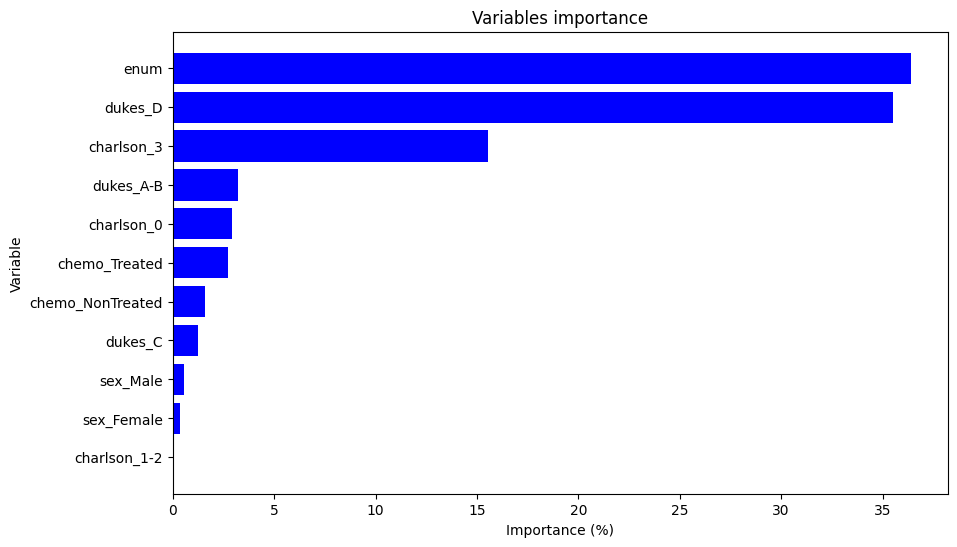

{'charlson_1-2': 5.4717741010119863e-14,
 'sex_Female': 0.3501906149022906,
 'sex_Male': 0.5617110874288065,
 'dukes_C': 1.2310851885201748,
 'chemo_NonTreated': 1.610803679829826,
 'chemo_Treated': 2.7258155599215574,
 'charlson_0': 2.901853390804541,
 'dukes_A-B': 3.195277597943444,
 'charlson_3': 15.528995157717032,
 'dukes_D': 35.498329525808394,
 'enum': 36.395938197123876}

In [45]:
model.get_pi_values(X_test, y_test, y_train, plot = True)   # Plot = True displays the variable importance. plot = False per default

### **SHAP**

For Shap, you can specify whether you want the summary plot with the option (plot=True), but you can also plot the graph representing SHAP values as a function of the values of a specified feature (feature=...).

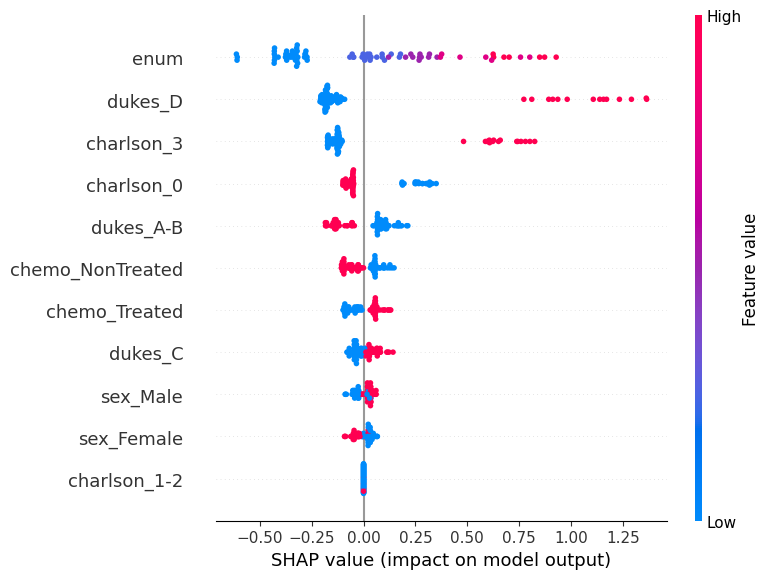

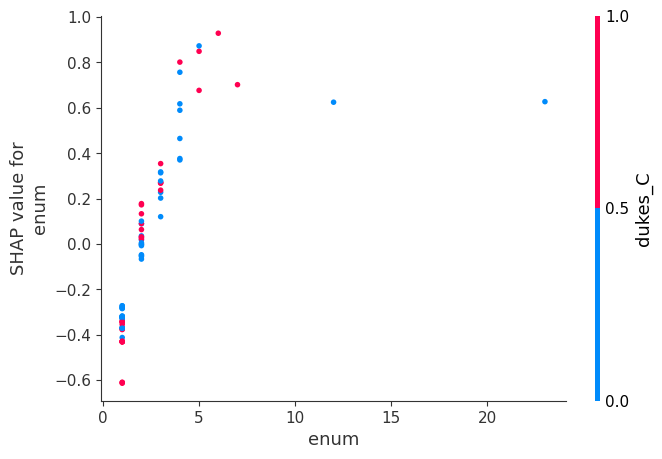

array([[ 5.09428157e-02,  5.49668449e-02, -1.76423300e-03,
        -4.29169943e-03,  9.40346691e-02, -3.84638348e-02,
         8.93048793e-01,  3.17748037e-01,  0.00000000e+00,
         6.27202998e-01,  3.13850109e-01],
       [-7.38595050e-02, -7.13093641e-02,  6.44222701e-02,
         5.82113056e-02,  1.05745697e-01,  6.15119088e-02,
        -1.30530146e-01, -9.88574130e-02,  0.00000000e+00,
        -1.71408434e-01,  2.71840337e-01],
       [-1.01734953e-01, -9.72316736e-02, -4.25538424e-02,
        -4.94477736e-02,  6.87557841e-02,  1.12129019e-02,
        -2.01503719e-01, -5.88693597e-02,  0.00000000e+00,
        -1.31769529e-01, -3.43275284e-01],
       [ 9.69018812e-02,  6.60077881e-02,  8.80592487e-03,
         2.44270365e-02,  1.71927980e-01, -3.62485550e-02,
         1.29181557e+00, -7.63341495e-02,  0.00000000e+00,
        -1.22117522e-01, -2.43929915e-04],
       [ 9.79315347e-02,  9.19696655e-02,  4.08328448e-02,
         3.91541244e-02,  1.79346417e-01,  1.12030351e-01,
  

In [46]:
model.get_shap_values(X_train, X_test, feature = 'enum',  plot=True)

### **LIME**

We use here the librairie survlimepy in order to generate LIME interpretation of survival models.

In [47]:
model.get_lime_explanation(X_train, X_test, y_test, sample_idx = [3,5])   # sample_idx represents the rows we want to analyse

## **Hyperparameters importance**

In [48]:
#The hyperparameters_range should contains only a list afo min_val or max_val, except for str hyperparameters (list of str you want to test)

hyperparameters_range_GB = {
    'learning_rate' : [0.001,0.5],
    'n_estimators' : [50,200],
    'max_depth' : [2,13],
    'subsample' : [0.01,1],
    'min_samples_split' : [3,14],
    'min_samples_leaf' : [3,13]
}

hyperparameters_range_RF = {
    'n_estimators' : [50,200],
    'max_depth' : [2,13],
    'max_samples' : [1e-3,0.9],
    'min_samples_split' : [3,14],
    'min_samples_leaf' : [3,13]
}

hyperparameters_range_SVM = {
    'max_iter' : [100,1000],
    'degree' : [2,5],
    'gamma' : [1e-5,1e3],
    'kernel' : ['linear', 'poly']
}

Progress of Hyperparameters importance:   0%|          | 0/1400 [00:00<?, ?it/s]

Hyperparameters : learning_rate


Progress of Hyperparameters importance:  14%|█▍        | 200/1400 [02:07<13:52,  1.44it/s]

Hyperparameters : n_estimators


Progress of Hyperparameters importance:  29%|██▊       | 400/1400 [04:02<14:15,  1.17it/s]

Hyperparameters : max_depth


Progress of Hyperparameters importance:  37%|███▋      | 520/1400 [05:15<15:26,  1.05s/it]

Hyperparameters : subsample


Progress of Hyperparameters importance:  51%|█████▏    | 720/1400 [07:51<08:06,  1.40it/s]

Hyperparameters : min_samples_split


Progress of Hyperparameters importance:  60%|██████    | 840/1400 [09:31<07:52,  1.19it/s]

Hyperparameters : min_samples_leaf


Progress of Hyperparameters importance:  69%|██████▊   | 960/1400 [11:21<05:12,  1.41it/s]


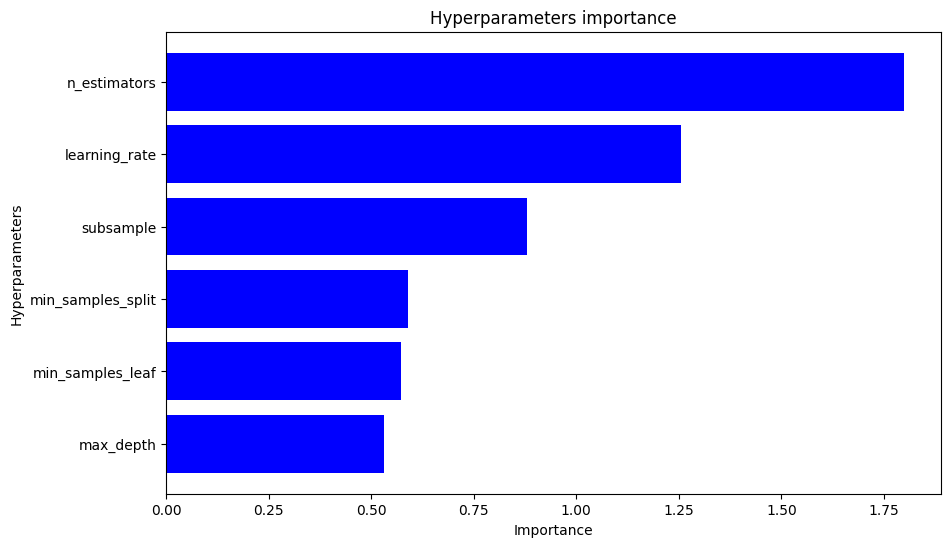

{'max_depth': 0.530931601359,
 'min_samples_leaf': 0.5716441852053898,
 'min_samples_split': 0.5887191872284683,
 'subsample': 0.8791919375791186,
 'learning_rate': 1.2561475276316156,
 'n_estimators': 1.8000905860686083}

In [49]:
model.hyperparameters_importances(hyperparameters_range_GB, X_train, y_train, n_trials = 20, n_samples = 10, plot = True)

## **Learning Curve**

This method displays the learning curve of the model, using n_sample for time

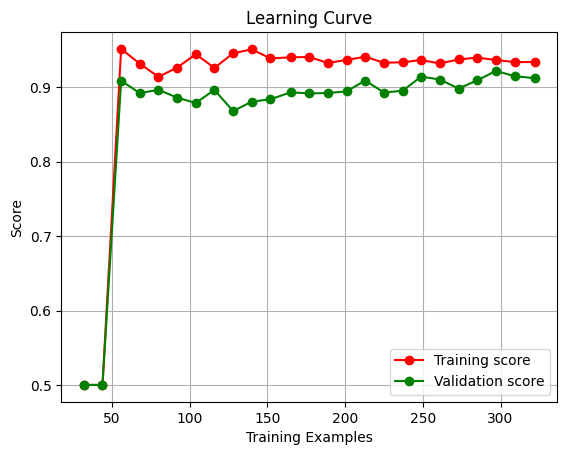

In [50]:
model.learning_curve(X_train, X_test, y_train, y_test, n_sample = 25)

## Comparaison with Cox model

In [13]:
model.compare_to_cox(df_rea_processed.drop(columns=['sex_Male','chemo_Treated','dukes_D','charlson_3']), X_test, y_test, y_train)

The ML model improves the score of 3.63% compared with the Cox model
